In [120]:
%matplotlib inline

import random
import gym
import numpy as np
import itertools
from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt

from IPython.display import clear_output

In [121]:
class DQN:
    def __init__(self, state_size, action_size, learning_rate):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate 

        self.model = self._build_model()
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [122]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        self.gamma = 0.95    # discount rate
        
        self.epsilon_start = 1.0  # exploration rate
        self.epsilon = self.epsilon_start
        self.epsilon_end = 0.01
        self.epsilon_decay_steps=5000
        self.epsilons = np.linspace(self.epsilon_start, self.epsilon_end, self.epsilon_decay_steps)

        self.learning_rate = 0.001
        self.memory = deque(maxlen=2000)
        self.update_target_network_every = 10
        
        self.policy_network = DQN(self.state_size, self.action_size, self.learning_rate)
        self.target_network = DQN(self.state_size, self.action_size, self.learning_rate)
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def epsilon_greedy(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.policy_network.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def greedy(self, state):
        act_values = self.policy_network.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def replay(self, batch_size):
        
        minibatch = random.sample(self.memory, batch_size)
        
        states, targets_f = [], []
        
        
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.target_network.model.predict(next_state)[0]))
                
            target_f = self.policy_network.model.predict(state)
            
            target_f[0][action] = target 
            # Filtering out states and targets for training
            states.append(state[0])
            targets_f.append(target_f[0])
            
        history = self.policy_network.model.fit(np.array(states), np.array(targets_f), epochs=1, verbose=0)
        # Keeping track of loss
        loss = history.history['loss'][0]
        
        return loss


In [123]:
def moving_average(a, n=3) :
                ret = np.cumsum(a, dtype=float)
                ret[n:] = ret[n:] - ret[:-n]
                return ret[n - 1:] / n

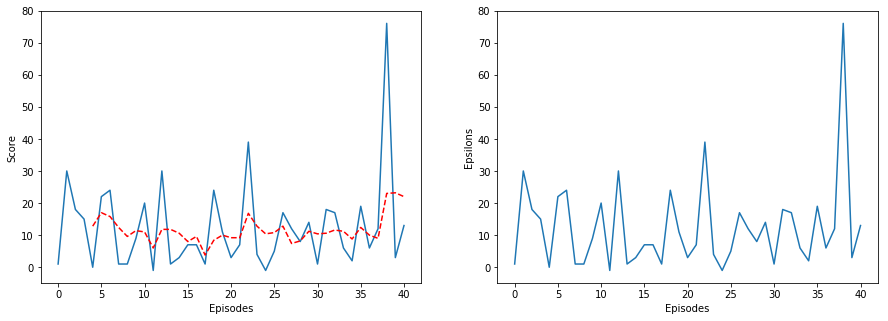

episode: 41/1000, score: 30, e: 0.81
episode: 42/1000, time: 0, loss: 0.0978
episode: 42/1000, time: 10, loss: 0.2501
episode: 42/1000, time: 20, loss: 1.7495
episode: 42/1000, time: 30, loss: 0.1026
episode: 42/1000, time: 40, loss: 0.1017
episode: 42/1000, time: 50, loss: 0.1187


In [ ]:
EPISODES = 1000

rolling_avg = 5

env = gym.make('CartPole-v0')

agent = Agent(env)

agent.policy_network.load("./save/cartpole-dqn.h5")
agent.target_network.load("./save/cartpole-dqn.h5")

rewards = np.zeros(EPISODES)

done = False
batch_size = 32
total_t = 0

for e in range(EPISODES):
    
    state = env.reset()

    state = np.reshape(state, [1, state_size])
    
    for t in itertools.count():
        # env.render()
        
        agent.epsilon = agent.epsilons[min(total_t, agent.epsilon_decay_steps-1)]
        
        action = agent.epsilon_greedy(state)
        next_state, reward, done, _ = env.step(action)
        
        reward = reward if not done else -10
        
        rewards[e] += reward
        
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            clear_output(wait=True)
            fig = plt.figure(figsize=(15,5))
            
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122)
            
            tmp_rewards = rewards[:e]
            
            avg_rewards = moving_average(tmp_rewards, n = rolling_avg)
            
            ax1.plot(range(e), tmp_rewards)
            ax1.plot(np.array(range(e))[rolling_avg - 1:], avg_rewards, ls='--', c='r')
            ax1.set(xlabel='Episodes',
                    ylabel='Score')
            
            ax2.plot(range(e), rewards[:e])
            ax2.set(xlabel='Episodes',
                    ylabel='Epsilons')
            
            plt.show()
            
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, t, agent.epsilon))
            break
        
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)
            # Logging training loss every 10 timesteps
            if t % 10 == 0:
                print("episode: {}/{}, time: {}, loss: {:.4f}"
                    .format(e, EPISODES, t, loss))
                
        total_t += 1
        
    # Maybe update the target estimator
    if e % agent.update_target_network_every == 0:
        agent.target_network.model.set_weights(agent.policy_network.model.get_weights()) 
        print("Copied model parameters to target network.")
    
    if e % 10 == 0:
        agent.policy_network.save("./save/cartpole-dqn.h5")    


In [126]:
env = gym.make('CartPole-v1')

agent = Agent(env)

# Play game
print("\nPlaying Game...")
agent.policy_network.load("./save/cartpole-dqn.h5")

s = env.reset()
done = False
while not done:
    env.render()
    a = agent.greedy(np.array([s]))
    newS, r, done, _ = env.step(a)
    s = newS
env.close()


Playing Game...


In [125]:
env.close()